This notebook parses census data from the American Community Survey website. The csv files included are for New York, NY, broken into 5-Digit Zip Code Tabulation Areas, and relate to household income (S1901) and public transportation commuting (S0801).

[Source](https://factfinder.census.gov/faces/nav/jsf/pages/searchresults.xhtml?refresh=t)

We used this data to identify zip codes to be investigated further through turnstile data.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('white')

In [6]:
#store the files for reference
income_raw = 'data/raw/ACS_15_5YR_S1901/ACS_15_5YR_S1901_with_ann.csv'
commute_raw = 'data/raw/ACS_15_5YR_S0801/ACS_15_5YR_S0801.csv'

In [7]:
#import census files and call columns for household income, commute by public transportation to work, and zip code
income_df = pd.read_csv(income_raw,
                       usecols = ['GEO.display-label', 'HC01_EST_VC01', 'HC01_EST_VC09', 'HC04_EST_VC10','HC01_EST_VC11']
                       )

commute_df = pd.read_csv(commute_raw, 
                         usecols = ['GEO.display-label', 'HC01_EST_VC10']
                        )

dfs = [income_df, commute_df]

for df in dfs:
    df.drop(0, inplace=True)
    df.reset_index(drop=True)

In [8]:
income_df.rename(columns = { 'GEO.display-label': 'zip_code',
                            'HC01_EST_VC01': 'total_households',
                           'HC01_EST_VC09': 'percent_100_149k',
                           'HC04_EST_VC10': 'percent_150_199k',
                           'HC01_EST_VC11': 'percent_200k_over'},
                 inplace=True
                )

In [6]:
commute_df.rename(columns = {'GEO.display-label': 'zip_code',
                            'HC01_EST_VC10': 'percent_public_trans'},
                 inplace = True
                 )

In [7]:
for df in dfs:
    df['zip_code'] = df['zip_code'].map(lambda x : str(x)[-5:])

In [8]:
for df in dfs:
    df.set_index('zip_code', inplace=True)

In [9]:
commute_df['percent_public_trans'].isnull().sum()

49

In [10]:
commute_df['percent_public_trans'].fillna(0, inplace=True)

In [11]:
len(income_df[income_df['percent_100_149k'] == '-']) == len(income_df[income_df['percent_150_199k'] == '-']) == len(income_df[income_df['percent_200k_over'] == '-'])

True

In [12]:
percents = {
            'percent_100_149k': 'total_100_149k',
            'percent_150_199k': 'total_150_199k',
            'percent_200k_over': 'total_200k_over'
           }

In [13]:
for percent in percents:
    income_df.loc[income_df[percent] == '-', percent] = 0

In [14]:
income_df['total_households'] = income_df['total_households'].apply(float)

for percent in percents:
    income_df[percent] = income_df[percent].apply(float)

commute_df['percent_public_trans'] = commute_df['percent_public_trans'].apply(float)

In [15]:
income_df.head()

,total_households,percent_100_149k,percent_150_199k,percent_200k_over
zip_code,,,,
10001,11639.0,13.2,10.3,22.1
10002,33348.0,8.5,3.9,5.9
10003,27487.0,15.2,10.9,22.5
10004,1574.0,22.0,12.8,28.0
10005,4252.0,24.6,12.9,27.4


In [16]:
for percent, total in percents.items():
    income_df[total] = (income_df['total_households'] * income_df[percent]).apply(round)/100

In [17]:
income_df['total_100k_over'] = income_df[percents.values()].sum(axis=1)

In [18]:
percents.values()

['total_100_149k', 'total_150_199k', 'total_200k_over']

In [19]:
census_df = income_df.join(commute_df)

In [20]:
census_df['percent_public_trans'].describe()

count    215.000000
mean      45.092093
std       23.916019
min        0.000000
25%       31.800000
50%       52.100000
75%       65.550000
max       89.000000
Name: percent_public_trans, dtype: float64

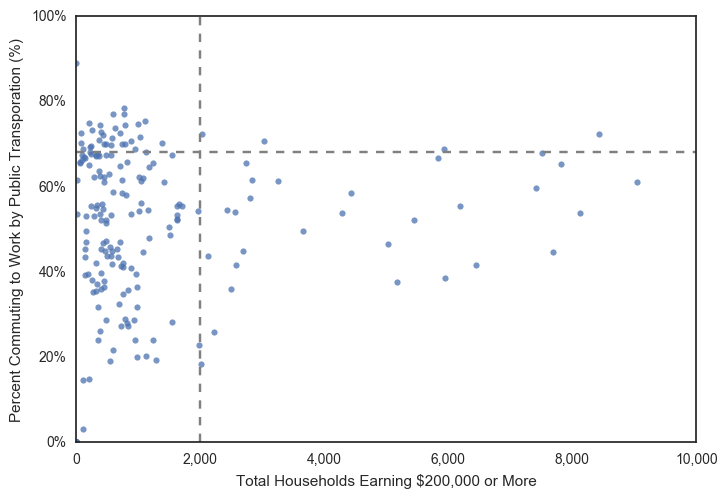

In [24]:
scatter = sns.regplot(x = 'total_200k_over',
            y = 'percent_public_trans',
            data = census_df, 
            scatter = True,
            fit_reg = False, 
            scatter_kws={'alpha': 0.75}
           );

#scatter.axes.set_title('Total Household Income vs. Percent Commuting to Work by Public Transportation');

scatter.vlines(2000, 0, 100, linestyle='dashed', colors='grey')
scatter.hlines(68, 0, 10000, linestyle='dashed', colors='grey')
scatter.set_xbound([0, 10000])
scatter.set_ybound([0, 100])

scatter.set_xlabel('Total Households Earning $200,000 or More')
scatter.set_ylabel('Percent Commuting to Work by Public Transporation (%)');

x_vals = scatter.get_xticks()
scatter.set_xticklabels([format(int(x), ',') for x in x_vals]);

y_vals = scatter.get_yticks()
scatter.set_yticklabels(['%d%%' % y for y in y_vals]);

scatter.get_figure().savefig('figures/scatter.png')

In [25]:
potential_zips = census_df[census_df['total_200k_over'] >= 2000]
potential_zips = potential_zips[potential_zips['percent_public_trans'] >= 68]

In [26]:
potential_zips.index.values

array([], dtype=object)